**Import Libraries**

In [1]:
import pandas as pd
import librosa
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Input
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

Load the Metadata

In [2]:

metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

Log-Mel

In [3]:

def extract_log_mel_spectrogram(file_path, n_mels=64, n_fft=2048, hop_length=512):
    try:
        audio, sample_rate = librosa.load(file_path, sr=None)  
        spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        feature_vector = np.mean(log_spectrogram, axis=1)
        return feature_vector
    except Exception as e:
        print(f"Error encountered while parsing file: {file_path}, error: {e}")
        return None


def process_audio_files(metadata):
    features = []
    for index, row in metadata.iterrows():
        file_name = os.path.join('UrbanSound8K/audio', f'fold{row["fold"]}', row["slice_file_name"])
        class_label = row["class"]
        data = extract_log_mel_spectrogram(file_name)
        if data is not None:
            features.append([data, class_label])
    return pd.DataFrame(features, columns=['feature', 'class_label'])

In [4]:

featuresdf = process_audio_files(metadata)


le = LabelEncoder()
featuresdf['class_label'] = le.fit_transform(featuresdf['class_label'])

In [5]:

X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [6]:

X_train = X_train[..., np.newaxis]  
X_test = X_test[..., np.newaxis]

In [7]:

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Neural Network Model

In [8]:
def create_NN(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),  
        Dropout(0.2),
        Dense(10, activation='softmax')  
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)


In [10]:
input_shape = (X_train_flat.shape[1],)  


NN_model = create_NN(input_shape)

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


nn_checkpoint = ModelCheckpoint('LogMel - nn_best_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
nn_early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')




In [11]:
NN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,570 (25.66 KB)

 Trainable params: 6,570 (25.66 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:

NN_history = NN_model.fit(X_train_flat, y_train, epochs=200, batch_size=32, 
                            validation_data=(X_test_flat, y_test), callbacks=[nn_checkpoint, nn_early_stopping])

Epoch 1/200
145/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1216 - loss: 29.9815
Epoch 1: val_loss improved from inf to 2.17019, saving model to LogMel - nn_best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1292 - loss: 25.1536 - val_accuracy: 0.2542 - val_loss: 2.1702
Epoch 2/200
146/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1897 - loss: 2.2221
Epoch 2: val_loss improved from 2.17019 to 2.11042, saving model to LogMel - nn_best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1898 - loss: 2.2218 - val_accuracy: 0.2679 - val_loss: 2.1104
Epoch 3/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1940 - loss: 2.1892
Epoch 3: val_loss improved from 2.11042 to 2.04446, saving model to LogMel - nn_best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1940 - loss: 2.1891 - val_accuracy: 0.2584 - val_loss: 2.0445
Epoch 4/200
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2055 - loss: 2.1484
Epoch 4: val

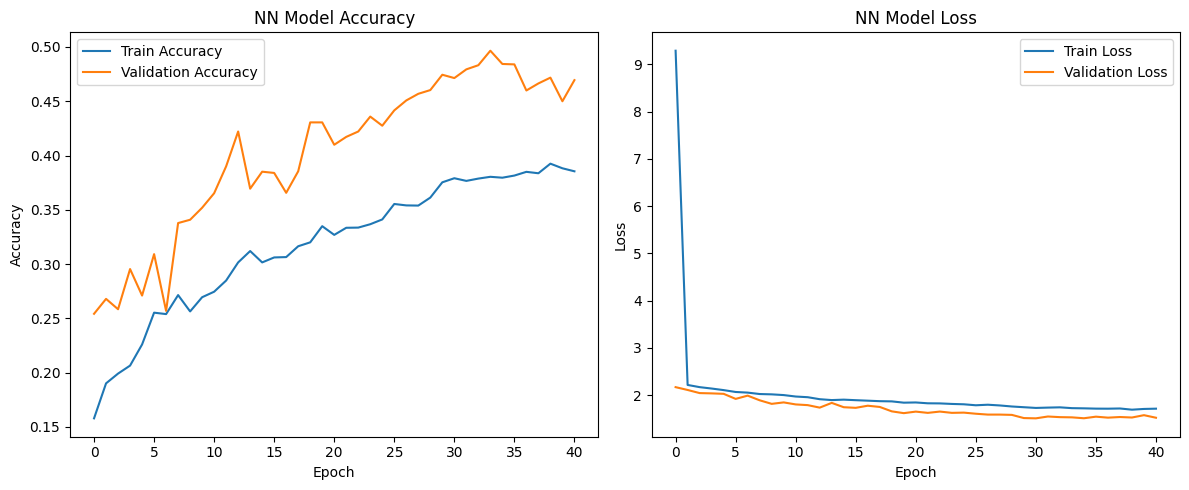

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(NN_history.history['accuracy'], label='Train Accuracy')
plt.plot(NN_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('NN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(NN_history.history['loss'], label='Train Loss')
plt.plot(NN_history.history['val_loss'], label='Validation Loss')
plt.title('NN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
from tensorflow.keras.models import load_model

model = load_model('LogMel - nn_best_model.keras')


In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import time


start_time = time.time()

y_pred = model.predict(X_test_flat)

end_time = time.time()

inference_time = end_time - start_time
print(f"Inference time: {inference_time:.4f} seconds")


y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


accuracy = accuracy_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Inference time: 0.3040 seconds
Accuracy: 0.47
F1 Score: 0.44


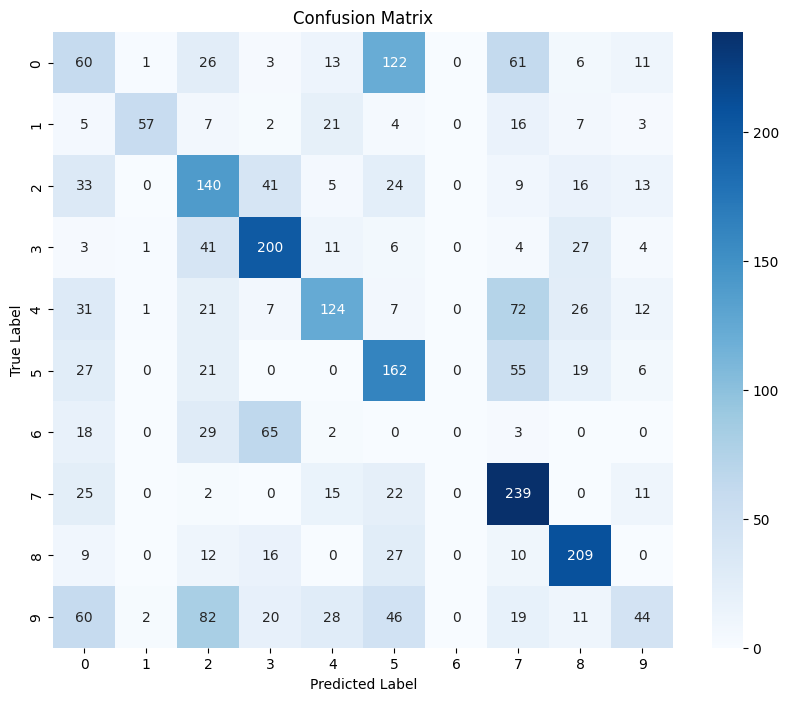

In [16]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [17]:
print(classification_report(y_true, y_pred_classes, zero_division=1))


              precision    recall  f1-score   support

           0       0.22      0.20      0.21       303
           1       0.92      0.47      0.62       122
           2       0.37      0.50      0.42       281
           3       0.56      0.67      0.61       297
           4       0.57      0.41      0.48       301
           5       0.39      0.56      0.46       290
           6       1.00      0.00      0.00       117
           7       0.49      0.76      0.60       314
           8       0.65      0.74      0.69       283
           9       0.42      0.14      0.21       312

    accuracy                           0.47      2620
   macro avg       0.56      0.44      0.43      2620
weighted avg       0.50      0.47      0.44      2620



In [18]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
#from scipy import interp
from itertools import cycle


In [19]:

n_classes = len(np.unique(y_true))
y_test_binarized = label_binarize(y_test, classes=range(n_classes))


In [20]:
class_names = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music"
]

In [21]:

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Print AUC-ROC Scores by class with class names
print("AUC-ROC Scores by class:")
for i in range(n_classes):
    print(f"{class_names[i]}: {roc_auc[i]:.2f}")
print(f"Micro-average AUC-ROC: {roc_auc['micro']:.2f}")

AUC-ROC Scores by class:
air_conditioner: 0.79
car_horn: 0.93
children_playing: 0.85
dog_bark: 0.91
drilling: 0.84
engine_idling: 0.87
gun_shot: 0.87
jackhammer: 0.92
siren: 0.93
street_music: 0.76
Micro-average AUC-ROC: 0.87


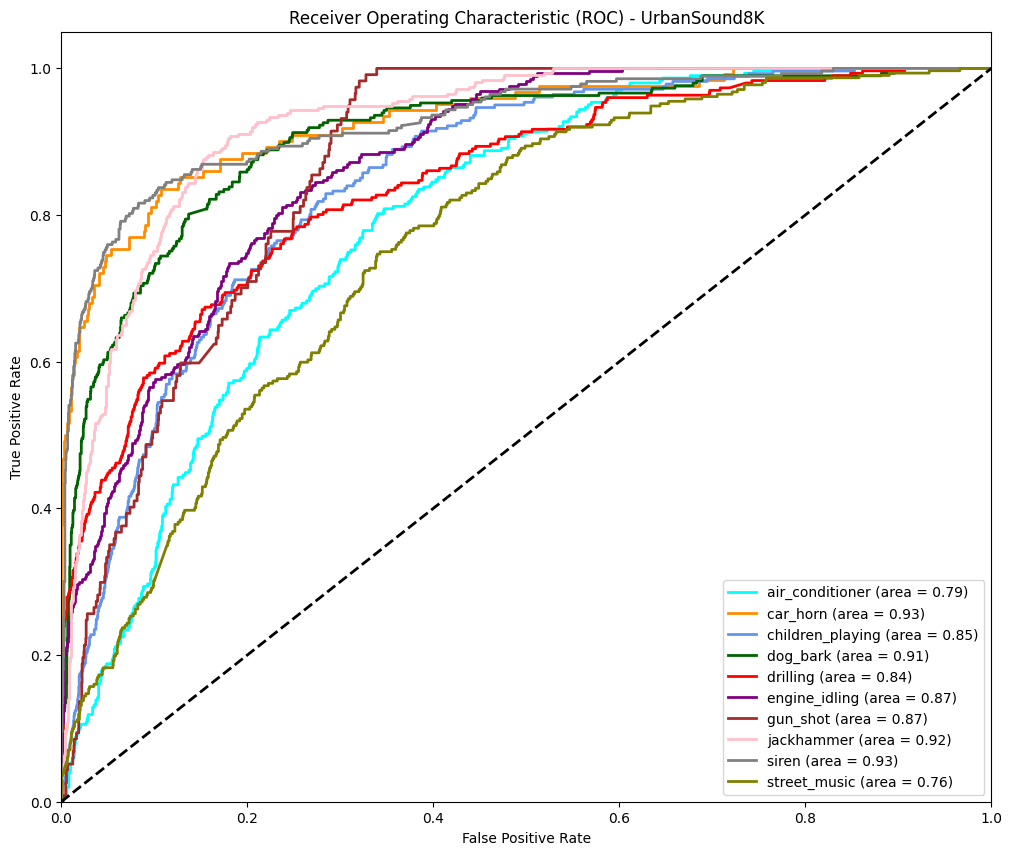

In [22]:

plt.figure(figsize=(12, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - UrbanSound8K')
plt.legend(loc="lower right")
plt.show()


CNN

In [23]:
def create_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(64, 3, activation='relu'),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Dropout(0.5),
        Conv1D(128, 3, activation='relu'),
        Conv1D(128, 3, activation='relu'),
        GlobalAveragePooling1D(),
        Dropout(0.5),
        Dense(y_train.shape[1], activation='softmax')  
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [24]:

checkpoint_path = "LogMel - CNN best_model.keras"


checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')


In [25]:
input_shape

(64,)

In [26]:

input_shape = (X_train.shape[1], 1)


CNNmodel = create_model(input_shape)

In [27]:
CNNmodel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 62, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 60, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 28, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 26, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,882 (343.29 KB)

 Trainable params: 87,882 (343.29 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:

CNNhistory = CNNmodel.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Epoch 1/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1156 - loss: 2.4615
Epoch 1: val_accuracy improved from -inf to 0.22710, saving model to LogMel - CNN best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.1157 - loss: 2.4604 - val_accuracy: 0.2271 - val_loss: 2.0667
Epoch 2/200
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1978 - loss: 2.0896
Epoch 2: val_accuracy improved from 0.22710 to 0.28206, saving model to LogMel - CNN best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1980 - loss: 2.0893 - val_accuracy: 0.2821 - val_loss: 1.9318
Epoch 3/200
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2575 - loss: 1.9722
Epoch 3: val_accuracy did not improve from 0.28206
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2577 - loss: 1.9720 - val_accuracy: 0.2378 - val_loss: 2.0119
Epoch 4/200
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3049 - loss: 1.8709
Epoch 4: val_accuracy improved from 0.2820

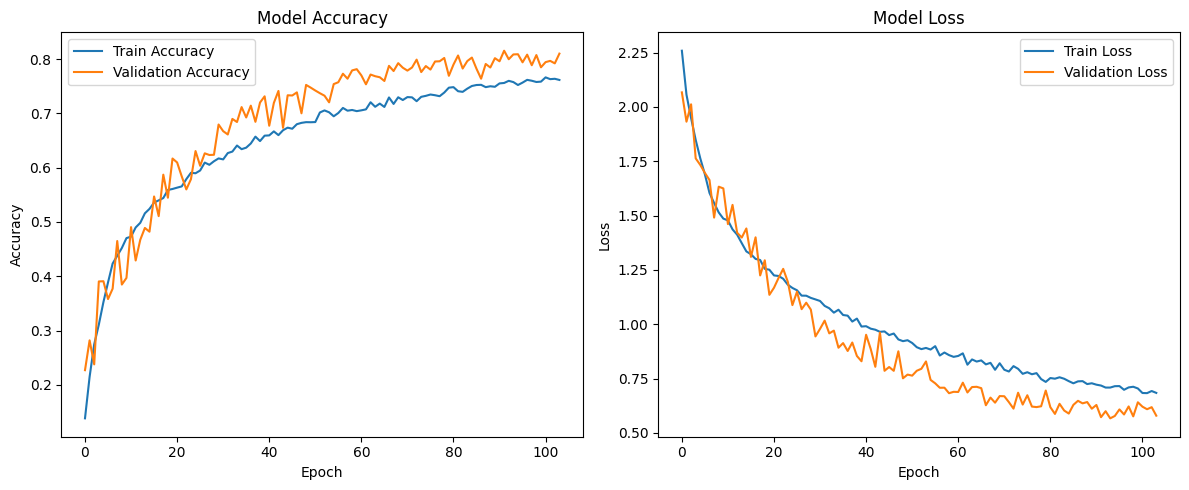

In [29]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(CNNhistory.history['accuracy'], label='Train Accuracy')
plt.plot(CNNhistory.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(CNNhistory.history['loss'], label='Train Loss')
plt.plot(CNNhistory.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [30]:
from tensorflow.keras.models import load_model

model = load_model('LogMel - CNN best_model.keras')


In [31]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import time

start_time = time.time()

y_pred = model.predict(X_test)
end_time = time.time()

inference_time = end_time - start_time
print(f"Inference time: {inference_time:.4f} seconds")

y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


accuracy = accuracy_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Inference time: 1.0926 seconds
Accuracy: 0.82
F1 Score: 0.82


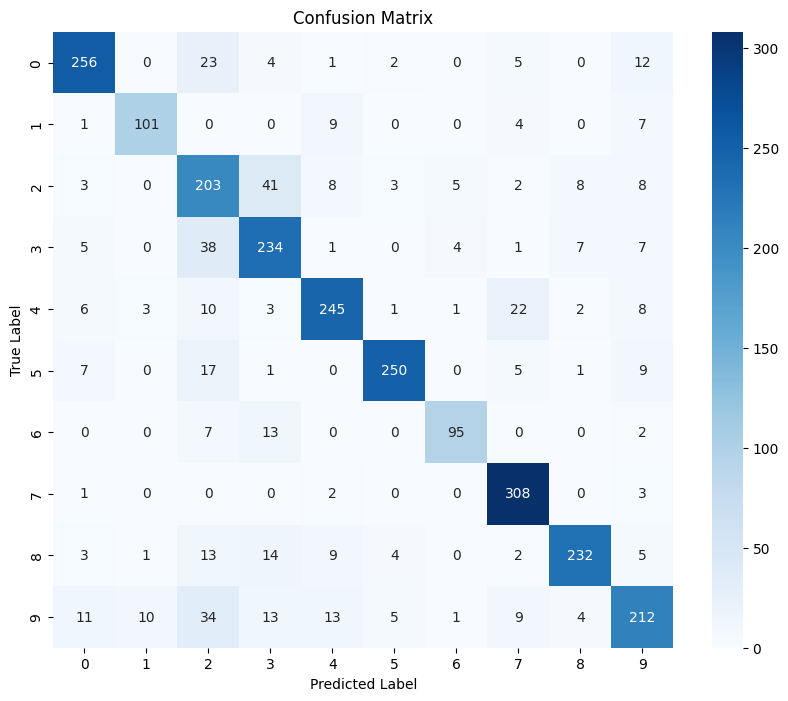

In [32]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [33]:
print(classification_report(y_true, y_pred_classes))


              precision    recall  f1-score   support

           0       0.87      0.84      0.86       303
           1       0.88      0.83      0.85       122
           2       0.59      0.72      0.65       281
           3       0.72      0.79      0.75       297
           4       0.85      0.81      0.83       301
           5       0.94      0.86      0.90       290
           6       0.90      0.81      0.85       117
           7       0.86      0.98      0.92       314
           8       0.91      0.82      0.86       283
           9       0.78      0.68      0.72       312

    accuracy                           0.82      2620
   macro avg       0.83      0.82      0.82      2620
weighted avg       0.82      0.82      0.82      2620



In [34]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
#from scipy import interp
from itertools import cycle


In [35]:

n_classes = len(np.unique(y_true))
y_test_binarized = label_binarize(y_test, classes=range(n_classes))


In [36]:
class_names = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music"
]

In [37]:

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


print("AUC-ROC Scores by class:")
for i in range(n_classes):
    print(f"{class_names[i]}: {roc_auc[i]:.2f}")
print(f"Micro-average AUC-ROC: {roc_auc['micro']:.2f}")

AUC-ROC Scores by class:
air_conditioner: 0.99
car_horn: 0.98
children_playing: 0.95
dog_bark: 0.97
drilling: 0.98
engine_idling: 0.99
gun_shot: 0.99
jackhammer: 1.00
siren: 0.98
street_music: 0.96
Micro-average AUC-ROC: 0.98


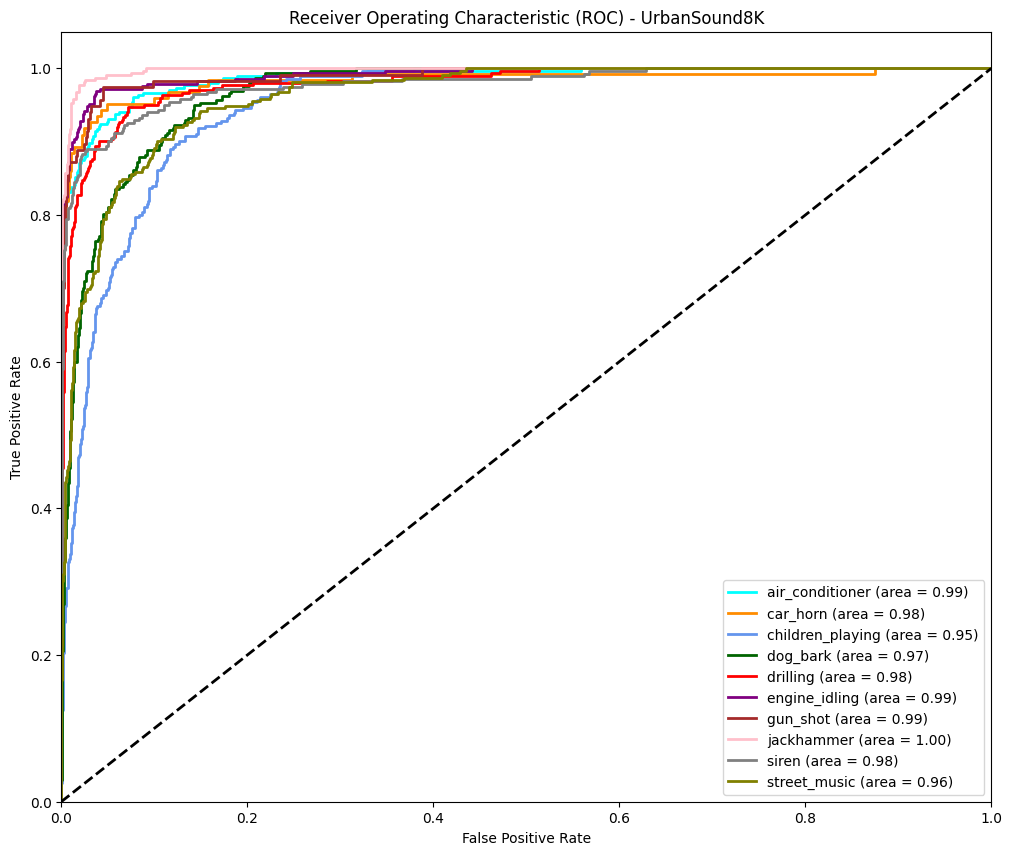

In [38]:

plt.figure(figsize=(12, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - UrbanSound8K')
plt.legend(loc="lower right")
plt.show()
